In [4]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#!pip install catboost

In [0]:
import pandas as pd
import numpy as np
from scipy import stats

pd.set_option("display.max_columns", 100)

In [0]:
df = pd.read_csv(
    "/content/gdrive/My Drive/Colab Notebooks/TaxiFare/train.csv", 
    index_col="tripid"
)
print(df.dtypes)
df.head()

In [0]:
label_df = pd.DataFrame(df['label'])
feature_df = df.drop(columns='label')
feature_df.head()

In [0]:
label_df['label_copy'] = label_df['label']
labels ={"label": {"correct": 1, "incorrect": 0}}
label_df.replace(labels, inplace=True)
label_df.head()

In [10]:
label_df['label'].value_counts()

1    15495
0     1681
Name: label, dtype: int64

In [0]:
label_df.drop(columns='label_copy', inplace=True)
label_df.head()

In [0]:
def set_trip_time(df):
    df['pickup_time'] = pd.to_datetime(df['pickup_time'])
    df['drop_time'] = pd.to_datetime(df['drop_time'])
    df['trip_time'] = (df['drop_time'] - df['pickup_time']).dt.total_seconds()
    df.drop(columns=['pickup_time', 'drop_time'], inplace=True)

# set_trip_time(feature_df)

In [0]:
def get_distance(lat1, lon1, lat2, lon2):
    # haversine_distance
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   lamb1 = np.radians(lon1)
   lamb2 = np.radians(lon2)

   delta_phi = phi2 - phi1
   delta_lambda = lamb2 - lamb1
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
   return np.round(res, 3)

def set_distance(feature_df):
    distances = []
    for row in feature_df.itertuples(index=False):
        distances.append(get_distance(row.pick_lat, row.pick_lon, row.drop_lat, row.drop_lon))
    
    feature_df['trip_distance'] = distances
    feature_df.drop(columns=['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], inplace=True)

# Calling the set_distance to set a distance column and remove coordinates columns
# set_distance(feature_df)

In [0]:

def set_time_error(feature_df):
    time_errors = []
    feature_df['time_error'] = (feature_df['duration'] - feature_df['trip_time'])**2
    #feature_df.drop(columns=['duration', 'trip_time'], inplace=True)

# set_time_error(feature_df)

In [0]:
def add_missing_col(df):
    '''
        This function adds an additional binary column to the df based on all
        additional_fare, duration, meter_waiting, meter_waiting_fare, meter_waiting_till_pickup, time_error
        has NaN values
    '''
    df['ismissing'] = np.where(df[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'time_error']].isnull().all(1), 1, 0)

# add_missing_col(feature_df)
# feature_df.head()

In [0]:
def feature_process(feature_df):
    set_trip_time(feature_df)
    set_distance(feature_df)
    set_time_error(feature_df)
    add_missing_col(feature_df)

    return feature_df

# Outlier Handling

## Z-Score

In [0]:
def remove_outliers(xdf, ydf):
    columns = xdf.columns
    index = xdf.index.values
    imputer = SimpleImputer(strategy='median')
    data = imputer.fit_transform(xdf)
    xdf = pd.DataFrame(data=data, columns=columns, index=index)
    xdf.index.name = 'tripid'
    z = np.abs(stats.zscore(xdf.drop(columns='ismissing')))
    #z = np.abs(stats.zscore(xdf))
    outliers = np.where(z > 3)[0]
    xdf = xdf.drop(xdf.index[outliers])
    ydf = ydf.drop(ydf.index[outliers])

    return (xdf, ydf, imputer)

# print("Before: {}|{}".format(feature_df.shape, label_df.shape))
# feature_df, label_df = remove_outliers(feature_df, label_df)
# print("After: {}|{}".format(feature_df.shape, label_df.shape))

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import f1_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

In [0]:
def preprocess_train(xdf, ydf):
    '''
        xdf - feature dataframe
    '''
    xdf = feature_process(xdf)
    columns = xdf.columns

    xdf, ydf, imputer = remove_outliers(xdf, ydf)

    scaler = MinMaxScaler()
    x_out = scaler.fit_transform(xdf)
    xdf = pd.DataFrame(x_out, columns=columns, index=xdf.index.values)


    out = {'xdf': xdf, 'ydf': ydf, 'imputer': imputer, 'scaler': scaler}
    return out

# out = preprocess_xtrain(features_df, numeric_cols, non_numeric_cols)
# df = out['df']
# df.head()

In [0]:
def preprocess_test(xdf, imputer, scaler):
    '''
        preprocess_xtrain() must be called on training data before using this

        xdf - feature dataframe
        imputer - nimputer returned by preprocess_xtrain()
        scaler - nscaler returned by preprocess_xtrain()
    '''
    xdf = feature_process(xdf)
    columns = xdf.columns
    x_out = imputer.transform(xdf)
    x_out = scaler.transform(x_out)
    df = pd.DataFrame(x_out, columns=columns, index=xdf.index.values)

    return df

# testdf = preprocess_xtest(features_df, numeric_cols, non_numeric_cols, 
#                               out['nimputer'], out['nscaler'], out['nnimputer'], out['nnscaler'], out['encoder'])
    
# testdf.head()

In [0]:
X_train, X_eval, y_train, y_eval = train_test_split(
    feature_df,
    label_df,
    test_size=0.33,
    shuffle=True,
    stratify=label_df,
    random_state=RANDOM_SEED
)

pre_out = preprocess_train(X_train, y_train)
X_train = pre_out['xdf']
y_train = pre_out['ydf']

X_eval = preprocess_test(X_eval, imputer=pre_out['imputer'], scaler=pre_out['scaler'])

eval_set = (X_eval, y_eval)

In [34]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier()

clf.fit(X_train, y_train)

Learning rate set to 0.029154
0:	learn: 0.6650487	total: 7.02ms	remaining: 7.01s
1:	learn: 0.6361117	total: 17.6ms	remaining: 8.78s
2:	learn: 0.6112980	total: 30.4ms	remaining: 10.1s
3:	learn: 0.5879713	total: 39.9ms	remaining: 9.93s
4:	learn: 0.5605933	total: 50.3ms	remaining: 10s
5:	learn: 0.5345084	total: 60.2ms	remaining: 9.97s
6:	learn: 0.5104686	total: 69.5ms	remaining: 9.86s
7:	learn: 0.4901204	total: 78.9ms	remaining: 9.79s
8:	learn: 0.4753318	total: 85.1ms	remaining: 9.37s
9:	learn: 0.4568903	total: 95ms	remaining: 9.4s
10:	learn: 0.4389237	total: 105ms	remaining: 9.43s
11:	learn: 0.4247030	total: 114ms	remaining: 9.42s
12:	learn: 0.4127981	total: 124ms	remaining: 9.39s
13:	learn: 0.3981181	total: 133ms	remaining: 9.39s
14:	learn: 0.3852953	total: 143ms	remaining: 9.38s
15:	learn: 0.3771894	total: 148ms	remaining: 9.09s
16:	learn: 0.3644512	total: 158ms	remaining: 9.13s
17:	learn: 0.3534684	total: 168ms	remaining: 9.15s
18:	learn: 0.3464131	total: 177ms	remaining: 9.16s
19:	le

In [0]:
preds = clf.predict(X_eval)

In [36]:
# Submission 20 - CatBoostClassifier()
print("F1_Score: {}".format(f1_score(y_eval, preds)))
print("Macro F1_Score: {}".format(f1_score(y_eval, preds, average='macro')))

F1_Score: 0.972962570961224
Macro F1_Score: 0.8378040368033632


Text(0.5, 15.0, 'Predicted')

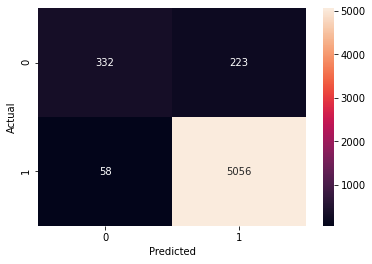

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_eval, preds)
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [0]:
importance = clf.get_feature_importance(prettified=True)
print(importance)

# Predicting on Test Data

In [38]:
%%time 

pre_out = preprocess_train(feature_df, label_df)
feature_df = pre_out['xdf']
label_df = pre_out['ydf']

clf = CatBoostClassifier()
clf.fit(feature_df, label_df)

Learning rate set to 0.034591
0:	learn: 0.6577907	total: 7.94ms	remaining: 7.93s
1:	learn: 0.6237977	total: 19.9ms	remaining: 9.91s
2:	learn: 0.5869466	total: 31.4ms	remaining: 10.4s
3:	learn: 0.5590765	total: 41.5ms	remaining: 10.3s
4:	learn: 0.5318099	total: 53.1ms	remaining: 10.6s
5:	learn: 0.5056102	total: 64.4ms	remaining: 10.7s
6:	learn: 0.4826972	total: 75.7ms	remaining: 10.7s
7:	learn: 0.4605296	total: 87.1ms	remaining: 10.8s
8:	learn: 0.4453024	total: 93.4ms	remaining: 10.3s
9:	learn: 0.4275603	total: 105ms	remaining: 10.4s
10:	learn: 0.4091262	total: 116ms	remaining: 10.4s
11:	learn: 0.3952131	total: 128ms	remaining: 10.5s
12:	learn: 0.3816543	total: 139ms	remaining: 10.6s
13:	learn: 0.3671978	total: 150ms	remaining: 10.6s
14:	learn: 0.3544540	total: 162ms	remaining: 10.6s
15:	learn: 0.3469489	total: 168ms	remaining: 10.3s
16:	learn: 0.3347376	total: 180ms	remaining: 10.4s
17:	learn: 0.3232022	total: 192ms	remaining: 10.5s
18:	learn: 0.3162944	total: 210ms	remaining: 10.9s
19

In [0]:
test_features_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/test.csv", 
                               index_col="tripid")

test_features_df = preprocess_test(test_features_df, imputer=pre_out['imputer'], scaler=pre_out['scaler'])
print(test_features_df.shape)

In [0]:
test_predictions = clf.predict(test_features_df)
# test_proba = full_pipeline.predict_proba(test_features_df)
# test_predictions = calibrate_imbalance(test_proba, 0.7)

In [0]:
submission_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/TaxiFare/sample_submission.csv", 
                            index_col="tripid")

In [44]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["prediction"] = test_predictions

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [0]:
submission_df.to_csv('/content/gdrive/My Drive/Colab Notebooks/TaxiFare/my_submission.csv', index=True)

In [0]:
!head /content/gdrive/My\ Drive/Colab\ Notebooks/TaxiFare/my_submission.csv